## A Simple Adaptive Stepsize ODE Solver

Freely translated from the C++ version presented in Numerical Recipes, itself translated from Dormand and Prince -- let's hope not too much was lost in translation!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 6.25]  # make the plots somewhat larger
plt.rcParams.update({'font.size': 18})       # make the fonts somewhat larger

The solution will be advanced by a single step $h$ using an $O(h^5)$ Runge-Kutta method due to Dormand and Prince. This particular method has the interesting feature that it has embedded in it it an $O(h^4)$ method. This allows one to easily estimate the truncation error per step from the difference in the two solutions.
(For details, see NR or the paper by Dormand and Prince referenced therein)

In [2]:
class RK45():
    """
    Dormand-Prince embedded Runge-Kutta method of orders 4 and 5
    Given:
       current solution 
    Returns:   
       solution at next step, error estimate
    """    
    def __init__(self):
        self.a = np.array(  [ 0,          0,     1/5,        3/10,          3/5,            1, 7/8])
        
        self.b = np.array([ [ 0,          0,       0,           0,            0,            0],
                            [ 0,          0,       0,           0,            0,            0],
                            [ 0,        1/5,       0,           0,            0,            0],
                            [ 0,       3/40,    9/40,           0,            0,            0],
                            [ 0,       3/10,   -9/10,         6/5,            0,            0],
                            [ 0,     -11/54,     5/2,      -70/27,        35/27,            0],
                            [ 0, 1631/55296, 175/512,   575/13824, 44275/110592,     253/4096] ])
        
        self.cc = np.array( [ 0,     37/378,       0,     250/621,      125/594,          0,   512/1771])
        
        ccs = np.array(     [ 0, 2825/27648,       0, 18575/48384,  13252/55296,  277/14336,       1/4 ])
        self.dc = self.cc - ccs

        self.pgrow = -0.2
        self.pshrink = -0.25
        self.safety = 0.9
        self.errcon = (5/self.safety)**(1/self.pgrow)
        
    def step(self, t, y, h, RHS, *P):
        n = len(y)
        k = np.zeros( (7,n) )

        a = self.a
        b = self.b
        cc = self.cc
        dc = self.dc
        
        k[1] = h * RHS(t+a[1]*h, y, *P)
        k[2] = h * RHS(t+a[2]*h, y + b[2,1]*k[1], *P)
        k[3] = h * RHS(t+a[3]*h, y + b[3,1]*k[1] + b[3,2]*k[2], *P)
        k[4] = h * RHS(t+a[4]*h, y + b[4,1]*k[1] + b[4,2]*k[2] + b[4,3]*k[3], *P)
        k[5] = h * RHS(t+a[5]*h, y + b[5,1]*k[1] + b[5,2]*k[2] + b[5,3]*k[3] + b[5,4]*k[4], *P)
        k[6] = h * RHS(t+a[6]*h, y + b[6,1]*k[1] + b[6,2]*k[2] + b[6,3]*k[3] + b[6,4]*k[4] + b[6,5]*k[5], *P)
        
        # solution
        yp = y + cc[1]*k[1] + cc[2]*k[2] + cc[3]*k[3] + cc[4]*k[4] + cc[5]*k[5] + cc[6]*k[6]
        # error estimate
        yerr =   dc[1]*k[1] + dc[2]*k[2] + dc[3]*k[3] + dc[4]*k[4] + dc[5]*k[5] + dc[6]*k[6]
    
        return yp, yerr

Given an estimate of the trucation error made after one step of size $h$, one can ask: What timestep should I have used to keep the error per step near some desired value $\epsilon_0$? One can use some simple control theory to derive expressions which will increase the timestep when the numerical solution is too accurate and decrease it (and perhaps repeat with a smaller step) when the solution is not accurate enough.

This is algorithm is known as *adaptive timestepping* and is the mainstay of most numerical ODE solvers.

In [3]:
class ivpSolve():
    def __init__(self, stepper):
        self.stepper = stepper()
        self.tiny = 1.0e-30

    def doStep(self, t, y, htry, RHS, aeps, reps, *P):
        
        h = htry  # start with suggested stepsize
    
        while True:
            # take an rk45 step, returning solution & estimate of error
            ytmp, yerr = self.stepper.step(t, y, h, RHS, *P)
        
            # scale result by yscale and compute ratio of scaled error to desired error, eps
            rerrmax = np.amax(np.abs(yerr/(np.abs(ytmp)+self.tiny))) / reps
            aerrmax = np.amax(np.abs(yerr)) / aeps
        
            # if the relative error is too large, shrink the stepsize and try again
            if rerrmax > 1:

                htry = self.stepper.safety * h * rerrmax**self.stepper.pshrink
                if htry < 0.1 * h:
                    h = 0.1 * h    # don't reduce by more than power of 10
                else:
                    h = htry
                    
                tnew = t + h       # worry about finite precision!
                if tnew == t:
                    raise ValueError("stepsize underflow in odeSolve")

                continue  # return for another iteration, using smaller error
                
            # if the absolute error is too large, shrink the stepsize and try again
            elif aerrmax > 1:
                htry = self.stepper.safety * h * aerrmax**self.stepper.pshrink
                if htry < 0.1 * h:
                    h = 0.1 * h    # don't reduce by more than power of 10
                else:
                    h = htry
                    
                tnew = t + h       # worry about finite precision!
                if tnew == t:
                    raise ValueError("stepsize underflow in odeSolve")

                continue  # return for another iteration, using smaller error

            # if the error is within desired bounds...
            else:
                errmax = max(aerrmax, rerrmax) # choose the larger error for scaling of h
            
                if errmax > self.stepper.errcon:
                    hnext = self.stepper.safety * h * errmax**self.stepper.pgrow  # if too small, increase stepsize
                else:
                    hnext = 5 * h                       # but limit to 5 * old stepsize
                    
                hdid = h # solution by the step we just succeeded in taking
                t += h
                y = ytmp
                break   # quit loop -- we did a step with acceptable error
                        
        return t, y, hdid, hnext
    

    def solve(self, t0, tmax, y0, RHS, h0, aeps, reps, hmin, dtsave, *P):
        """
        Integrate the given initial value problem from t0 to tmax, starting with initial condition y0,
            keeping the absolute error below aeps and relative error reps per step. Don't let the
            timestep fall below hmin.
            Save the computed solution every ~dtsave if dtsave>0
        """
        maxstep = 10000000    # may need to alter this...
        
        t = t0
        h = h0
        nok, nbad = 0,0     # number of successful steps and number of retries

        y = y0                # initial condition
        tsave = t - 2*dtsave
        if dtsave>0:
            tout = []
            yout = []
            
        for nstep in range(0, maxstep):
            dydt = RHS(t, y, *P)
        
            # if requested, save output at intermediate times
            if dtsave > 0 and np.abs(t-tsave) > np.abs(dtsave):
                tout.append(t)
                yout.append(y)
                tsave = t
            
            if (t+h-tmax)*(t+h-t0) > 0:   # don't let solution go beyond tmax
                h = tmax - t
            
            # take a step
            t, y, hdid, hnext = self.doStep(t, y, h, RHS, aeps, reps, *P)

            if hdid == h:
                nok += 1
            else:
                nbad += 1

            if (t-tmax)*(tmax-t0) >= 0 :   # are we done?
                if dtsave > 0:
                    tout.append(t)
                    yout.append(y)
                    return y, nok, nbad, np.array(tout),np.array(yout)
                else:
                    return y, nok, nbad
                
            if np.abs(hnext) < hmin:
                raise ValueError("setpsize too small in odeSolve")
            
            h = hnext
        
        raise ValueError("too many steps in odeSolve")

To illustrate, let's return to the Lotke-Voltera system we used earlier:

In [4]:
def lvRHS(t, y, *P):
    # Lotke-Volterra system RHS
    
    # unpack the parameters from the array P
    alpha, beta, gamma, delta = P

    # make temporary variables with rabbit and fox populations
    R = y[0]
    F = y[1]
    
    # LV system
    dRdt = alpha * R - beta * R * F
    dFdt = delta * R * F - gamma * F
    
    # return an array of derivatives with same order as input vector
    return np.array([ dRdt, dFdt ])

Now set up the system and solve. We plot both the solution and the timestep chosen over the course of the integration. You can see that, when the solution is rapidly changing, the timestep shrinks, while when the derivatives are of smaller magnitude the timestep grows.

Such behavior ensures that (at least the local truncation) error stays bounded as desired. It also makes the solution more efficient as the fewest timesteps are required.

12077 0


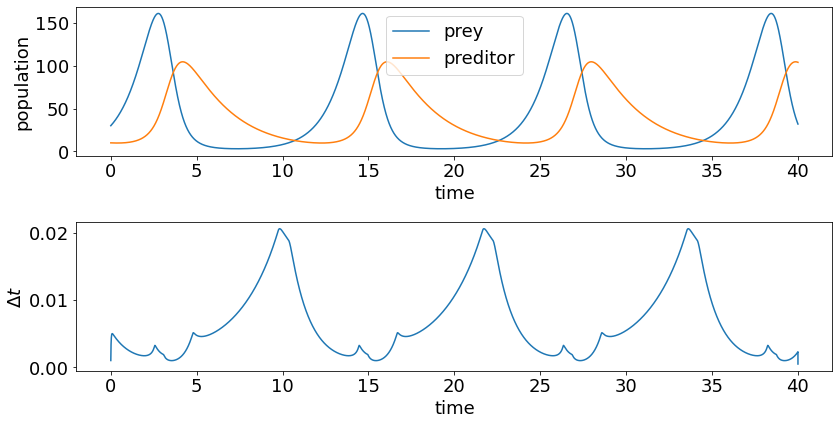

In [7]:
alpha = 1.0 
beta = 0.025
gamma = 0.4
delta = 0.01

solver = ivpSolve(RK45) #instantiate the solver class

t0 = 0
tmax = 40
y0 = np.array([30.0, 10.0])
h0 = 0.001
aeps = 1.0e-3
reps = 1.0e-4
hmin = 1.0e-8

dtmin = 0.0001

y, nok, nbad, ta, ya = solver.solve(t0, tmax, y0, lvRHS, h0, aeps, reps, hmin, dtmin, alpha, beta, gamma, delta)

print(nok, nbad) 

fig, ax = plt.subplots(2,1)
ax[0].plot(ta, ya[:,0], label='prey')
ax[0].plot(ta, ya[:,1], label='preditor')
ax[0].set_xlabel(r"time")
ax[0].set_ylabel(r"population")
ax[0].legend()

dt = ta[1:]-ta[:-1]
ax[1].plot(ta[1:], dt)
ax[1].set_xlabel(r"time")
ax[1].set_ylabel(r"$\Delta t$")

plt.tight_layout()
plt.show()